In [41]:
import os
from ast import literal_eval

import numpy as np
from scipy.stats import friedmanchisquare, wilcoxon
from scikit_posthocs import posthoc_nemenyi_friedman
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn

import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
sns.set_style('white', {'font.family':'serif'})
sns.set_context("paper", font_scale = 3)

# Load data and pre-process

In [42]:
in_dir = "../data/eval_data"  # This should store all the datasets as csv files, according to the sampling notebooks
datasets = ["LAR_1.csv", "LAR_2.csv", "NY.csv", "congress.csv"]  # Target datasets
systems = ["aws","presidio", "gcp"] # System labels

data = dict()
for d in datasets:
    data[d] = pd.read_csv(os.path.join(in_dir, d), index_col=0)

### There are some processing issues address in this section:

- The congressional data has some folks in multiple groups.  This is grouped into a 'multiracial' category.  Note that this 'multiracial' group actually includes people with 2+ non-White race/ethnic identities listed, since White is not an explicit category

- The pii-benchmarking code marks "Bernie Sanders" "\*\*\*\*\*\*\*\*\*\*\*\*\*", but GCP returns "\*\*\*\*\*\* \*\*\*\*\*\*\*".  We need to make sure multi-word names are scored appropriately

- GCP had a strange bug where, for one template, entity indices were offset by 2.  We don't take this bug into account, because we want to gauge the performance effects based on names.  In other words, this isn't a standard benchmarking performance study.

- We fill names for some datasets with an 'N' tag which aren't marked explicitly for a certain gender.

In [43]:
# For congressional data, multiracial is grouped into one category
def map_group(group_name):
    if ',' in group_name:
        return 'MULTI'
    return group_name

data['congress.csv']['Group'] = data['congress.csv'].apply(lambda x: map_group(x['Group']), axis=1)

In [44]:
# Account for spaces between multiple names in the Congress dataset

def fix_multi_labels(entities, start_char, end_char, current):
    entities = literal_eval(entities)
    i = 0
    while i < len(entities):
        if entities[i]['start_char'] <= start_char and entities[i]['end_char'] >= end_char:
            # Return full match
            return entities[i]['entity_label']         
        elif entities[i]['start_char'] <= start_char:
            i += 1
            while i < len(entities):
                # We only accept a single space for multiple words
                if entities[i]['start_char'] - entities[i-1]['end_char'] > 1:
                    break
                # Return multiple match
                elif entities[i]['end_char'] >= end_char:
                    return entities[i]['entity_label']
                i += 1
        else:
            i += 1
    return current

for sys in ['aws', 'gcp', 'presidio']:
    recall = f"Recall_{sys}"
    ents = f"Entities_{sys}"
    data['congress.csv'][recall] = data['congress.csv'].apply(lambda x: fix_multi_labels(x[ents],
                                                                              x['Start_index'], x['End_index'], x[recall]), axis=1)

In [45]:
# For some reason GCP offset the entity labels of template #12 by 2 chars, we are accounting for the offset here

def fix_offset_labels(templateId, entities, start_char, end_char, current):
    if templateId == 12:
        for entity in literal_eval(entities):
            if entity['start_char'] <= start_char + 2 and entity['end_char'] >= end_char + 2:
                return entity['entity_label']
    return current

for d in datasets:
    data[d][f"Recall_gcp"] = data[d].apply(lambda x: fix_offset_labels(x['TemplateId'], x['Entities_gcp'],
                                                x['Start_index'], x['End_index'], x['Recall_gcp']), axis=1)

In [46]:
# Fill NA in NYC (no specified gender)

data['NY.csv']['Gender'] = data['NY.csv']['Gender'].fillna('N')

### Here we get the correctness or recall per system, as True or False:

- We check that the label of the target text was marked correctly as PERSON_NAME
- It won't be marked PERSON_NAME if it is another tag, like LOCATION, or a no-match or partial-match


In [47]:
# Based on the recalled label, get the recall per instance


for k, v in data.items():
    for system in systems:
        v[f"Score_{system}"] = v[f"Recall_{system}"].apply(lambda x: x=='PERSON_NAME')
    data[k] = v
    
systems = ["Score_aws", "Score_gcp", "Score_presidio"]

# Descriptive stats

We get FNR averages for each system and dataset, by race/ethnicity group and/or gender

In [48]:
def get_fnr(df):
    return df.mean().apply(lambda x: 1 - x) * 100

def is_group_present(cols, grouping):
    """For a certain dataset, some groups (like gender) might not be present and we skip those."""
    cols = cols.to_list()
    if type(grouping)==list:
        for g in grouping:
            if g not in cols:
                return False
        return True
    else:
        return grouping in cols


def print_means(d, grouping):
    """Print average FNR for each system/dataset"""
    for k, v in d.items():
        if is_group_present(v.columns, grouping):
            print(k)
            print(f"Overall:\n\n{get_fnr(v[systems])}\n\n")
            print(get_fnr(v.groupby(grouping)[systems]))
            

def print_count(d, grouping):
    """Print observations of names per group"""
    for k, v in d.items():
        if is_group_present(v.columns, grouping):
            print(k)
            print(v.groupby(grouping)['Name'].count() / 32) # count of names, not templates
            print('\n')

In [49]:
print_count(data, "Group")

LAR_1.csv
Group
black         20.0
hispanic     172.0
white       1000.0
Name: Name, dtype: float64


LAR_2.csv
Group
api       441.0
white    1000.0
Name: Name, dtype: float64


NY.csv
Group
ASIAN AND PACIFIC ISLANDER    165.0
BLACK NON HISPANIC            226.0
HISPANIC                      389.0
WHITE NON HISPANIC            592.0
Name: Name, dtype: float64


congress.csv
Group
AF        56.0
AS        16.0
HA        48.0
IA         4.0
MULTI      6.0
WO       410.0
Name: Name, dtype: float64




In [50]:
print_means(data, "Group")

LAR_1.csv
Overall:

Score_aws         22.276112
Score_gcp         17.643666
Score_presidio    20.868289
dtype: float64


          Score_aws  Score_gcp  Score_presidio
Group                                         
black     20.000000  18.125000       29.531250
hispanic  28.415698  12.445494       24.672965
white     21.265625  18.528125       20.040625
LAR_2.csv
Overall:

Score_aws         29.285219
Score_gcp         28.569570
Score_presidio    26.849844
dtype: float64


       Score_aws  Score_gcp  Score_presidio
Group                                      
api    38.194444  51.183390       29.202098
white  25.356250  18.596875       25.812500
NY.csv
Overall:

Score_aws         24.605958
Score_gcp         36.837190
Score_presidio    25.191327
dtype: float64


                            Score_aws  Score_gcp  Score_presidio
Group                                                           
ASIAN AND PACIFIC ISLANDER  21.250000  43.617424       22.083333
BLACK NON HISPANIC          28.871

In [51]:
print_count(data, "Gender")

NY.csv
Gender
F    741.0
M    618.0
N     13.0
Name: Name, dtype: float64


congress.csv
Gender
F    148.0
M    392.0
Name: Name, dtype: float64




In [52]:
print_means(data, "Gender")

NY.csv
Overall:

Score_aws         24.605958
Score_gcp         36.837190
Score_presidio    25.191327
dtype: float64


        Score_aws  Score_gcp  Score_presidio
Gender                                      
F       23.675776  39.802632       25.092780
M       25.561286  33.146238       25.262945
N       32.211538  43.269231       27.403846
congress.csv
Overall:

Score_aws         12.795139
Score_gcp          7.320602
Score_presidio     8.177083
dtype: float64


        Score_aws  Score_gcp  Score_presidio
Gender                                      
F       10.916385   8.192568        8.403716
M       13.504464   6.991390        8.091518


In [53]:
print_count(data, ["Group", "Gender"])

NY.csv
Group                       Gender
ASIAN AND PACIFIC ISLANDER  F          86.0
                            M          77.0
                            N           2.0
BLACK NON HISPANIC          F         122.0
                            M         101.0
                            N           3.0
HISPANIC                    F         212.0
                            M         175.0
                            N           2.0
WHITE NON HISPANIC          F         321.0
                            M         265.0
                            N           6.0
Name: Name, dtype: float64


congress.csv
Group  Gender
AF     F          26.0
       M          30.0
AS     F          10.0
       M           6.0
HA     F          14.0
       M          34.0
IA     F           2.0
       M           2.0
MULTI  F           1.0
       M           5.0
WO     F          95.0
       M         315.0
Name: Name, dtype: float64




In [54]:
print_means(data, ["Group", "Gender"])

NY.csv
Overall:

Score_aws         24.605958
Score_gcp         36.837190
Score_presidio    25.191327
dtype: float64


                                   Score_aws   Score_gcp  Score_presidio
Group                      Gender                                       
ASIAN AND PACIFIC ISLANDER F       20.094477   43.023256       22.165698
                           M       22.118506   43.993506       22.159091
                           N       37.500000   54.687500       15.625000
BLACK NON HISPANIC         F       30.148566   62.807377       34.656762
                           M       27.042079   47.277228       29.207921
                           N       38.541667  100.000000       60.416667
HISPANIC                   F       18.352005   35.716392       21.255896
                           M       22.232143   32.232143       21.089286
                           N       17.187500   54.687500       28.125000
WHITE NON HISPANIC         F       25.691199   32.895249       24.776090
      

In [55]:
# Poor performance on gender 'neutral' names is notable
get_fnr(data['NY.csv'].query("Gender=='N'").groupby(['Name', 'Group']))[systems]

,,Score_aws,Score_gcp,Score_presidio
Name,Group,,,
Angel,HISPANIC,25.000,100.000,43.750
Charlie,WHITE NON HISPANIC,9.375,9.375,9.375
Finley,WHITE NON HISPANIC,18.750,6.250,18.750
Jaylin,HISPANIC,9.375,9.375,12.500
Jia,ASIAN AND PACIFIC ISLANDER,53.125,100.000,12.500
Nana,BLACK NON HISPANIC,12.500,100.000,34.375
Parker,WHITE NON HISPANIC,93.750,6.250,9.375
Phoenix,BLACK NON HISPANIC,25.000,100.000,68.750
Quinn,WHITE NON HISPANIC,31.250,6.250,12.500


# Processing for Statistical analysis
We remove anything that has < 15 support

In [56]:
# For analysis some congressional groups are < 15 names, these will not be included
print(f"Congress groups:\n{data['congress.csv']['Group'].value_counts() / 32}")
data['congress.csv'] = data['congress.csv'][data['congress.csv']['Group'].isin(['WO', 'AF', 'HA', 'AS'])]

# For NYC data, we don't use names that aren't FEMALE or MALE assigned for our intersectional analysis
data['NY.csv'] = data['NY.csv'].query("Gender == 'M' or Gender == 'F'", engine='python')

Congress groups:
WO       410.0
AF        56.0
HA        48.0
AS        16.0
MULTI      6.0
IA         4.0
Name: Group, dtype: float64


# False Negative Equality Difference

Getting the normalized FNED scores across datasets.

In [57]:
def get_fnr_series(series):
    return 1 - series.mean()

def get_fned(df, system='aws', groups=None, column='Group'):
    """Average variability in the FNR."""
    score = 0
    overall_FNR = get_fnr_series(df[system])
    
    if not groups:
        groups = set(df[column])

    n = 0
    for g in groups:
        group_name = f"{column}=='{g}'"
        temp_df = df.query(group_name)
        temp_FNR = get_fnr_series(temp_df[system])
        score += abs(overall_FNR - temp_FNR)
        n += 1
    return score / n * 100

In [58]:
for dataset in ['LAR_1.csv', 'LAR_2.csv', 'NY.csv', 'congress.csv']:
    print(f"\n{dataset}")
    for system in systems:
        print(system)
        print(f"Overall FNR: {get_fnr_series(data[dataset][system])}")
        print(f"NFNED: {get_fned(data[dataset], system=system)}")


LAR_1.csv
Score_aws
Overall FNR: 0.22276111577181212
NFNED: 3.142061417199941
Score_gcp
Overall FNR: 0.1764366610738255
NFNED: 2.1879882355236453
Score_presidio
Overall FNR: 0.20868288590604023
NFNED: 4.431767175225013

LAR_2.csv
Score_aws
Overall FNR: 0.29285218598195695
NFNED: 6.41909722222222
Score_gcp
Overall FNR: 0.2856956974323387
NFNED: 16.293257511337867
Score_presidio
Overall FNR: 0.26849843858431643
NFNED: 1.6947987528344644

NY.csv
Score_aws
Overall FNR: 0.24533204562178068
NFNED: 3.602048686195658
Score_gcp
Overall FNR: 0.3677566225165563
NFNED: 8.923362261198092
Score_presidio
Overall FNR: 0.2517016188373804
NFNED: 3.704083060637775

congress.csv
Score_aws
Overall FNR: 0.12889150943396221
NFNED: 3.5962337254563606
Score_gcp
Overall FNR: 0.07340801886792447
NFNED: 2.154958830848841
Score_presidio
Overall FNR: 0.08148584905660372
NFNED: 1.6841030357005904


In [59]:
# Datasets with gender
for dataset in ['NY.csv', 'congress.csv']:
    print(f"\n{dataset}")
    for system in systems:
        print(system)
        print(f"NFNED: {get_fned(data[dataset], system=system, column='Gender')}")


NY.csv
Score_aws
NFNED: 0.9427552146797191
Score_gcp
NFNED: 3.328196857434851
Score_presidio
NFNED: 0.08508247841410577

congress.csv
Score_aws
NFNED: 1.2914240931482357
Score_gcp
NFNED: 0.6139442454097588
Score_presidio
NFNED: 0.19144648454992863


# Friedman Chi Square tests and Wilcoxon Sign rank tests

We report 15 total Friedman and Wilcoxon tests, and adjust p-values for 'significance'

0.05 / 15 = 0.003

In [60]:
for d in data:
    for system in systems:
        data[d][system] = 1 - data[d][system]

In [61]:
# Friedman tests and post-hoc Nemenyi tests for all datasets with >2 groups

def get_fnrs_grouped(df, groups=['Group', 'TemplateId']):
    return df.groupby(groups).mean().apply(lambda x: 1-x).reset_index()

def friedman_test(df, column_name):
    subset = get_fnrs_grouped(df, groups=[column_name, 'TemplateId'])
    for system in systems:
        print(system +':\n')
        temp = subset.pivot(index=column_name, columns='TemplateId')[[system]]
        values = temp.values.tolist()
        if len(temp.values.tolist()) < 3:
            print(wilcoxon(*values))
            print('\n')
        else:
            print(friedmanchisquare(*values))
            print('\n')
            print(f"{dict(enumerate(temp.index.tolist()))}")
            print(posthoc_nemenyi_friedman(list(zip(*temp.values.tolist()))))
            print('\n')

for dataset in datasets:
    print(f"{dataset}---------------------------------------")
    friedman_test(data[dataset], 'Group')

LAR_1.csv---------------------------------------
Score_aws:

FriedmanchisquareResult(statistic=37.90243902439025, pvalue=5.882879334253639e-09)


{0: 'black', 1: 'hispanic', 2: 'white'}
          0      1         2
0  1.000000  0.001  0.291414
1  0.001000  1.000  0.001000
2  0.291414  0.001  1.000000


Score_gcp:

FriedmanchisquareResult(statistic=54.2, pvalue=1.7006680014814055e-12)


{0: 'black', 1: 'hispanic', 2: 'white'}
          0      1         2
0  1.000000  0.001  0.002132
1  0.001000  1.000  0.001000
2  0.002132  0.001  1.000000


Score_presidio:

FriedmanchisquareResult(statistic=15.266666666666667, pvalue=0.00048404468393305726)


{0: 'black', 1: 'hispanic', 2: 'white'}
          0         1         2
0  1.000000  0.642968  0.001000
1  0.642968  1.000000  0.016423
2  0.001000  0.016423  1.000000


LAR_2.csv---------------------------------------
Score_aws:

WilcoxonResult(statistic=20.0, pvalue=1.2380795614564472e-05)


Score_gcp:

WilcoxonResult(statistic=1.0, pvalue=6.748

In [62]:
for d in ['NY.csv', 'congress.csv']:
    print(f"{d}--------------------------")
    temp = data[d][data[d]['Gender'].isin(['M', 'F'])]
    friedman_test(temp, 'Gender')

NY.csv--------------------------
Score_aws:

WilcoxonResult(statistic=64.0, pvalue=0.0005287248371505039)


Score_gcp:

WilcoxonResult(statistic=0.0, pvalue=1.4271335760730118e-06)


Score_presidio:

WilcoxonResult(statistic=226.0, pvalue=0.8936415915787894)


congress.csv--------------------------
Score_aws:

WilcoxonResult(statistic=22.0, pvalue=9.461042463496435e-06)


Score_gcp:

WilcoxonResult(statistic=0.0, pvalue=1.0144446281440423e-07)


Score_presidio:

WilcoxonResult(statistic=121.0, pvalue=0.10218567179848317)




In [63]:
# Friedman tests and post-hoc Nemenyi tests for intersectionality
d = 'NY.csv'
print(f"{d}------------------------------------------")

subset = get_fnrs_grouped(temp, groups=['Group', 'Gender', 'TemplateId'])
subset["Intersection"] = subset["Group"] + '_' + subset["Gender"]

for system in systems:
    print(system +':\n')
    temp = subset.pivot(index='Intersection',columns='TemplateId')[[system]]
    print(friedmanchisquare(*temp.values.tolist()))
    print('\n')
    print(f"{dict(enumerate(temp.index.tolist()))}")
    print(posthoc_nemenyi_friedman(list(zip(*temp.values.tolist()))))
    print('\n')

NY.csv------------------------------------------
Score_aws:

FriedmanchisquareResult(statistic=111.18804433887564, pvalue=5.205096506634292e-21)


{0: 'AF_F', 1: 'AF_M', 2: 'AS_F', 3: 'AS_M', 4: 'HA_F', 5: 'HA_M', 6: 'WO_F', 7: 'WO_M'}
          0         1         2         3         4         5         6  \
0  1.000000  0.900000  0.206040  0.001000  0.049210  0.900000  0.006415   
1  0.900000  1.000000  0.733655  0.007049  0.002171  0.900000  0.001000   
2  0.206040  0.733655  1.000000  0.456160  0.001000  0.886199  0.001000   
3  0.001000  0.007049  0.456160  1.000000  0.001000  0.017303  0.001000   
4  0.049210  0.002171  0.001000  0.001000  1.000000  0.001000  0.900000   
5  0.900000  0.900000  0.886199  0.017303  0.001000  1.000000  0.001000   
6  0.006415  0.001000  0.001000  0.001000  0.900000  0.001000  1.000000   
7  0.900000  0.472739  0.007737  0.001000  0.535342  0.309817  0.184092   

          7  
0  0.900000  
1  0.472739  
2  0.007737  
3  0.001000  
4  0.535342  
5  0

# Analyzing the data

First look at highest and lowest scoring names for each dataset

In [64]:
# Best and worst scoring names

cols = ['Score_avg']
for dataset in ['LAR_1.csv', 'LAR_2.csv']:
    temp = data[dataset].groupby(['Name', 'Group'])[systems].mean()
    temp['Score_avg'] = 1 - temp.mean(axis=1)
    temp = temp.sort_values('Score_avg')
    print(dataset)
    print(temp[cols].head(10))
    print(temp[cols].tail(10))

LAR_1.csv
                   Score_avg
Name     Group              
German   hispanic   0.000000
Houston  white      0.125000
Denver   white      0.135417
Royal    white      0.145833
Said     white      0.156250
Guy      white      0.156250
August   white      0.166667
Forest   white      0.166667
Page     white      0.166667
Chastity white      0.166667
               Score_avg
Name    Group           
Bob     white   0.927083
Kristan white   0.927083
Vicki   white   0.927083
Nickie  white   0.927083
Lesley  white   0.927083
Bethann white   0.927083
Brendan white   0.927083
Ruthann white   0.927083
Kerry   white   0.927083
Kaylyn  white   0.927083
LAR_2.csv
            Score_avg
Name Group           
Man  api     0.000000
My   api     0.000000
In   api     0.031250
Do   api     0.062500
So   api     0.062500
Son  api     0.062500
Thai api     0.083333
See  api     0.083333
An   api     0.093750
Tu   api     0.104167
                 Score_avg
Name      Group           
Delynn    whit

In [65]:
# Continue best and worst scoring names

cols = ['Score_avg']
for dataset in ['NY.csv', 'congress.csv']:
    temp = data[dataset].groupby(['Name', 'Group', 'Gender'])[systems].mean()
    temp['Score_avg'] = 1 - temp.mean(axis=1)
    temp = temp.sort_values('Score_avg')
    print(dataset)
    print(temp[cols].head(10))
    print(temp[cols].tail(10))

NY.csv
                                    Score_avg
Name     Group              Gender           
Egypt    BLACK NON HISPANIC F        0.010417
Empress  BLACK NON HISPANIC F        0.031250
Asia     BLACK NON HISPANIC F        0.031250
Major    BLACK NON HISPANIC M        0.031250
Malaysia BLACK NON HISPANIC F        0.041667
Justice  BLACK NON HISPANIC M        0.041667
Princess BLACK NON HISPANIC F        0.052083
Royalty  BLACK NON HISPANIC F        0.083333
Symphony BLACK NON HISPANIC F        0.083333
Alpha    BLACK NON HISPANIC M        0.093750
                                   Score_avg
Name    Group              Gender           
Kaylie  HISPANIC           F        0.927083
Keith   BLACK NON HISPANIC M        0.927083
Lena    WHITE NON HISPANIC F        0.927083
Brody   WHITE NON HISPANIC M        0.927083
Brendan WHITE NON HISPANIC M        0.927083
Lesley  HISPANIC           F        0.927083
Kareem  BLACK NON HISPANIC M        0.927083
Reid    WHITE NON HISPANIC M        

## Looking at the character length of the name

- Performance is poor for shortest names, but especially for short API and Black names.
- We can see API names are short in LAR2, where they perform particularly poorly, compared to NYC.


In [66]:
# Set up name length plots
for d in datasets:
    data[d]['Name_len'] = data[d]['Name'].apply(lambda x: len(x))
    data[d]['Score_avg'] = data[d][systems].mean(axis=1)
    data[d]['Dataset'] = d

def gather_all_names(data):
    names_all = pd.concat([data[d] for d in ['LAR_1.csv', 'LAR_2.csv', 'NY.csv']]).reset_index()
    map_cats = {'white': 'White', 'WHITE NON HISPANIC': 'White', 'api': 'API', 'ASIAN AND PACIFIC ISLANDER': 'API', 'black': 'Black', 'hispanic': 'Hispanic', 'BLACK NON HISPANIC': 'Black', 'HISPANIC':'Hispanic'}
    names_all['Group'] = names_all['Group'].apply(lambda x: map_cats[x])
    return names_all

names_all = gather_all_names(data)

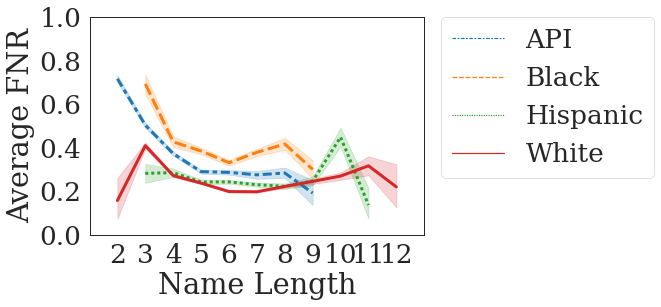

In [67]:
# Performance on names
name_len_plot = sns.lineplot(data=names_all, x='Name_len', y='Score_avg', hue='Group', style='Group', hue_order = ['API', 'Black', 'Hispanic', 'White'], linewidth=3)
name_len_plot.set(xlabel='Name Length')
name_len_plot.set(ylabel='Average FNR')
name_len_plot.set(xlim=(1, 13))
name_len_plot.set_xticks(ticks = range(2, 13))
name_len_plot.set_yticks(ticks = np.arange(0, 1.1, 0.2))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
name_len_plot
plt.savefig("length_FNR_group.png", dpi=300, bbox_inches="tight")

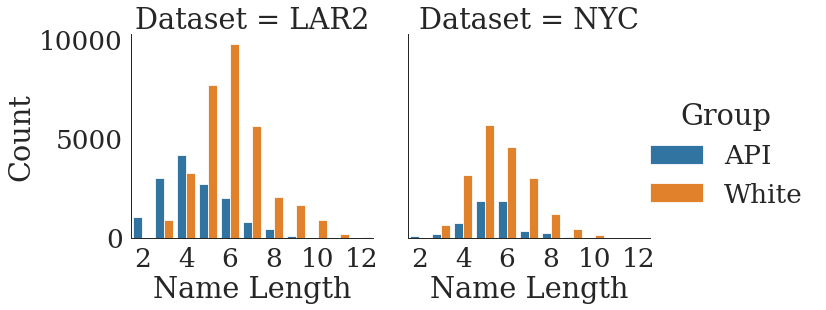

In [74]:
# Create a datset of API and White for LAR2 and NYC
ny_api_white = data['NY.csv'][data['NY.csv']['Group'].isin(['ASIAN AND PACIFIC ISLANDER', 'WHITE NON HISPANIC'])]
ny_api_white = ny_api_white[['Group', 'Name_len']]
ny_api_white['Dataset'] = 'NYC'

api_white_df = data['LAR_2.csv'][['Group', 'Name_len']]
api_white_df['Dataset'] = 'LAR2'

api_white_df = pd.concat([api_white_df, ny_api_white]).reset_index()

map_cats = {'white': 'White', 'WHITE NON HISPANIC': 'White', 'api': 'API', 'ASIAN AND PACIFIC ISLANDER': 'API'}
api_white_df['Group'] = api_white_df['Group'].apply(lambda x: map_cats[x])

# Group and plot
api_white_len_plot = api_white_df.groupby(['Group', 'Name_len', 'Dataset']).count().reset_index()

fplot = sns.catplot(data=api_white_len_plot, x="Name_len", y="index", hue='Group', col="Dataset", kind="bar")
fplot.set(xticks=range(0,12, 2), xlabel='Name Length')
fplot.set(ylabel='Count')
plt.savefig("length_API.png",dpi=300)

## Names which double as common words

- We add word net sense that include ANY senses that aren't specifically listed as a person.  We're looking to see how overlapping senses affect a person's name
- The effect of overlapping senses can be worse for certain groups i.e. Black-associated names.
- It's interesting to note how very similar name pairs like Joy and Hope perform differently.

In [69]:
# Adding Word Net senses

def in_lex_not_person(name):
    name = name.lower()
    synsets = wn.synsets(name)
    if synsets:
        lexnames = list()
        for s in synsets:
            lexnames.append(s.lexname())
        if any([x != 'noun.person' for x in lexnames]):
            return True
    return False


for d in datasets:
    data[d]['WordNet'] = data[d]['Name'].apply(lambda x: in_lex_not_person(x))

# 'Overlapping' names do score differently
names_all = gather_all_names(data)
names_all.groupby('WordNet').mean()['Score_avg']

WordNet
False    0.239869
True     0.419407
Name: Score_avg, dtype: float64

In [70]:
# Looking at the distribution of 'overlapping' names across sets.
names_all.groupby(['Dataset', 'Group']).mean()['WordNet']

Dataset    Group   
LAR_1.csv  Black       0.100000
           Hispanic    0.052326
           White       0.151000
LAR_2.csv  API         0.197279
           White       0.030000
NY.csv     API         0.116564
           Black       0.219731
           Hispanic    0.074935
           White       0.143345
Name: WordNet, dtype: float64

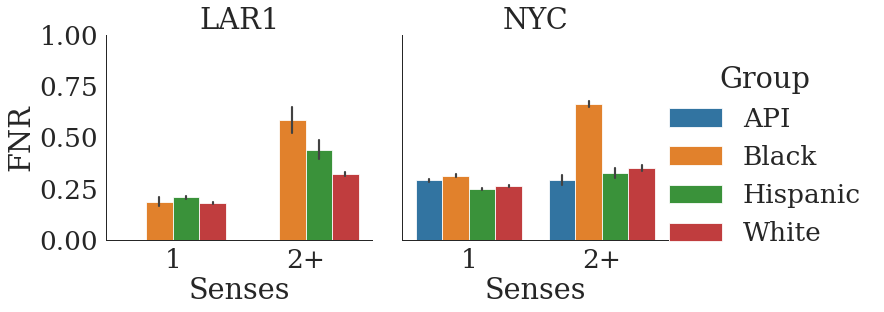

In [75]:
plot_wordnet = names_all.query("Dataset!='LAR_2.csv'")
d = {True: '2+', False: '1'}
plot_wordnet['WordNet'] = plot_wordnet['WordNet'].map(d)
fplot = sns.catplot(data=plot_wordnet, x="WordNet", order=['1', '2+'], y="Score_avg", hue='Group', col="Dataset", kind="bar", hue_order = ['API', 'Black', 'Hispanic', 'White'])
fplot.set(yticks=[0.00, 0.25, 0.50, 0.75, 1.00])
fplot.set(xlabel='Senses')
fplot.set(ylabel='FNR')

titles = ["LAR1", "NYC"]
for ax, title in zip(fplot.axes.flat, titles):
    ax.set_title(title)
    
plt.savefig("wordnet_FNRs.png", dpi=300, bbox_inches="tight")

In [72]:
simplified_nyc = data['NY.csv'].groupby(['Name', 'Group', 'Gender'])[systems].mean()

adj_names = ['Joy', 'Hope', 'Blessing']
for name in adj_names:
    print(name)
    print(simplified_nyc.loc[name])
    print('\n')

Joy
                                   Score_aws  Score_gcp  Score_presidio
Group                      Gender                                      
ASIAN AND PACIFIC ISLANDER F         0.28125     0.1875          0.3125


Hope
                           Score_aws  Score_gcp  Score_presidio
Group              Gender                                      
BLACK NON HISPANIC F             1.0        1.0         0.46875


Blessing
                           Score_aws  Score_gcp  Score_presidio
Group              Gender                                      
BLACK NON HISPANIC F             1.0        1.0          0.5625




In [73]:
loc_names = ['Egypt', 'Asia', 'Savanna', 'Georgia']
for name in loc_names:
    print(name)
    print(simplified_nyc.loc[name])
    print('\n')

Egypt
                           Score_aws  Score_gcp  Score_presidio
Group              Gender                                      
BLACK NON HISPANIC F         0.96875        1.0             1.0


Asia
                           Score_aws  Score_gcp  Score_presidio
Group              Gender                                      
BLACK NON HISPANIC F             1.0        1.0         0.90625


Savanna
                 Score_aws  Score_gcp  Score_presidio
Group    Gender                                      
HISPANIC F          0.1875        1.0         0.40625


Georgia
                           Score_aws  Score_gcp  Score_presidio
Group              Gender                                      
WHITE NON HISPANIC F            0.25        1.0         0.96875


